In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
#import matplotlib as mpl
import cv2  # conda install -c conda-forge opencv
#from moviepy.editor import VideoFileClip

#%matplotlib notebook
import matplotlib.pyplot as plt
#%matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
#plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
#!pip install ipympl
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# Analysis

In [2]:
vid_path = "./data/videos/individual-rotifer/"
trim_duration = 7
vid_filename = f"2024_0205_101231_022_{trim_duration}sec.mov"  # d_high
vid_extension = vid_filename.split("sec")[-1]
vid_filename = vid_filename.split(".")[0]

vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"
seg_mask_path = f"./data/results/{vid_filename}_masks"  # inching w/o substrate, then sample then take-off, 315 frames

video = cv2.VideoCapture(vid_filepath)
fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
resolution = (height,width)#duration = frame_count / fps
video.release()
print(fps, resolution)

60 (1032, 920)


# Frame extraction

In [3]:
EXTRACT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5  # correspond to seg-masks

if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True)
    video = cv2.VideoCapture(vid_filepath)
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()

In [4]:
# Construct output figure path
save_figure_path = "_".join(seg_mask_path.split("_")[:-1])
os.makedirs(save_figure_path, exist_ok=True)
save_figure_path = os.path.join(save_figure_path, vid_filename)

### Get Segmentation Mask and video properties

In [5]:
# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Construct the dataframe
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

num_frames = len(df)
print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)

# Adjust resolution depending on frame rate
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Load in the segmentation masks and find contrours
from utils import get_contours_from_segmasks, get_contour_stats
segmentation_mask_filepaths = df["mask_fpath"].tolist()
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths)

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
df.head(5)

num_frames: 410 ; save_figure_path: ./data/results/2024_0205_101231_022_7sec/2024_0205_101231_022_7sec ; fps: 60 ; resolution: (1032, 920)
FHD, pixel_per_real_width =  0.61


,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
0,0,0.000000,./data/results/2024_0205_101231_022_7sec_masks...,260,394,21449.0,123543,0.173616,1072.444866,1.114114,131.253479,NaN,./data/images/2024_0205_101231_022_7sec/frame_...,1
1,1,0.016707,./data/results/2024_0205_101231_022_7sec_masks...,260,395,21521.5,123210,0.174673,1067.515932,1.111111,131.319107,1.0,./data/images/2024_0205_101231_022_7sec/frame_...,0
2,2,0.033415,./data/results/2024_0205_101231_022_7sec_masks...,259,395,21688.0,123543,0.175550,1066.586997,1.114114,131.321289,1.0,./data/images/2024_0205_101231_022_7sec/frame_...,0
3,3,0.050122,./data/results/2024_0205_101231_022_7sec_masks...,259,395,21510.5,122840,0.175110,1064.344356,1.114458,131.383575,0.0,./data/images/2024_0205_101231_022_7sec/frame_...,0
4,4,0.066830,./data/results/2024_0205_101231_022_7sec_masks...,259,395,21477.0,123172,0.174366,1065.758570,1.117470,131.444046,0.0,./data/images/2024_0205_101231_022_7sec/frame_...,0


## Rotate images and masks according to mask

In [6]:
rot_imgs = []
rot_masks = []
rot_contours = []

for nth, row in df.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotatation parameters
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    angle = row["orientation"]  # fitted ellipse angle
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask, and get contour
    rot_imgs.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    rot_masks.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))
    _, thresh = cv2.threshold(rot_masks[-1], 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rot_contours.append(contours[-1])

# mask an image

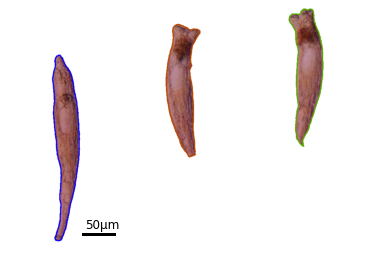

In [7]:
SAVE_FIGURES = False
highlight_frames = [8, 263, 338]  # 51, 

desired_scale_width = 50  # in mu
scaled_width = desired_scale_width / (pixel_per_real_width)
contour_lw = 2  # contor line width

fig, ax = plt.subplots(figsize=(5,8), nrows=1, ncols=len(highlight_frames), layout="constrained")

scalebar_posxy = [550, 1000]
ylow, yhigh = 400, 1030
xlow, xhigh = 350, 650
for nth, cframe in enumerate(highlight_frames):
    
    # ROTATED Masking the Image and contour
    cimg = rot_imgs[cframe]
    cmask = rot_masks[cframe]
    cnt = rot_contours[cframe]
    background = np.ones_like(cimg) * 255
    
    ccolors = tuple([c * 255 for c in colors[cframe]])
    masked_image = cv2.bitwise_and(cimg, cimg, mask=cmask)
    masked_image = np.where(masked_image != 0, masked_image, background)
    
    # Draw contour on image
    cv2.drawContours(masked_image, [cnt], 0, ccolors, contour_lw)
    ax[nth].imshow(masked_image)

    # Axis
    ax[nth].set_ylim([ylow, yhigh]); ax[nth].set_xlim([xlow, xhigh])
    ax[nth].invert_yaxis()
    ax[nth].set_axis_off()

# Scalebar
ax[0].plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=3)
ax[0].text(scalebar_posxy[0] + (scaled_width/20), scalebar_posxy[-1] - 15, f"{desired_scale_width}µm", size="large")

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-Individual-frames-highlighted_{highlight_frames}.jpg", dpi=300)

## Plot raw images and overlay mask contour

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_43340/950811960.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # can also set limits in next cell or give back the ax handle?!


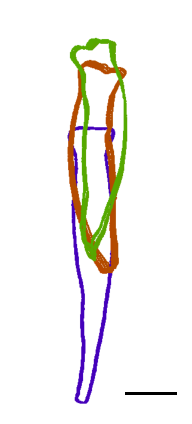

In [8]:
SAVE_FIGURES = False # Scale bar > can be moved somewhere else or config for defaults

# Frame selection
selected_frames1 = np.arange(50, 57, 1)
selected_frames2 = np.arange(260, 265+2, 1)
selected_frames3 = np.arange(335, 340+2, 1)
selected_frames = np.concatenate((selected_frames1, selected_frames2, selected_frames3))
#print(df.loc[selected_frames, "time"])
scalebar_posxy = [550, 1000]
cxlim = [350, 650]
cylim = [350, 1040]

desired_scale_width = 50  # in mu
scaled_width = desired_scale_width / (pixel_per_real_width)

# Prep subsampled data
sub_maskpaths = df["mask_fpath"].tolist()[::every_nth_frame]
first_frame = cv2.imread(sub_maskpaths[0])
background = np.ones_like(first_frame) * 255

# Draw selected contours
for sframe in selected_frames:
    ccolors = colors[sframe]
    ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
    cv2.drawContours(background, [rot_contours[sframe]], 0, (ccolors[0], ccolors[1], ccolors[2]), 2)

# Figure
plt.figure(figsize=(5,6), layout="constrained")
plt.imshow(background)
plt.ylim([ylow, yhigh]); plt.xlim([xlow, xhigh])
plt.xlim(cxlim); plt.ylim(cylim);
plt.gca().invert_yaxis()
plt.axis("off")

# Scalebar
plt.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=3)
#plt.text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] - 15, f"{desired_scale_width} µm", size="x-large")
plt.tight_layout() # can also set limits in next cell or give back the ax handle?!

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-fps_{fps}-subsampled_selected-frames.jpg", dpi=300)

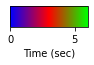

In [9]:
import matplotlib as mpl
fig = plt.figure(figsize=(1.2, .8), layout='constrained')
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=int(df["time"].max())), cmap=mpl.cm.brg),
             cax=fig.gca(), orientation='horizontal', label='Time (sec)')
if SAVE_FIGURES: fig.savefig(f"{save_figure_path}-colorbar.jpg", dpi=300)

## Fit ellipse and orient anterior-posterior

In [10]:
import skimage.morphology as morph

rot_imgs = []
rot_masks = []
rot_thin = []

for nth, row in df.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotate
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    #center = (row["centroid_x"], row["centroid_y"])
    angle = row["orientation"]  # fitted ellipse angle
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask, thin
    rot_imgs.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    rot_masks.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))
    
    #if  nth % every_nth_frame == 0:
        # Thinning / skeletonize
    # ALREADY THINNED > TAKE CARE OF THIS!!!
    #cthin = morph.thin(cmask).astype("uint8")
        #print(nth, cimg.dtype, cmask.dtype, cthin.dtype)
    #rot_thin.append(cv2.warpAffine(src=cthin, M=rotate_matrix, dsize=(w, h)))


In [11]:
SAVE_VIDEO = False

if SAVE_VIDEO:
    video = cv2.VideoWriter(f"{vid_filename}_rotate_test_video_center_color_slowmo.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=30, frameSize=(w, h), isColor=True)
    counter = 0

    for frame in rot_imgs:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.putText(frame, f"frame{str(counter).zfill(zfill_)}", (500,500), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        video.write(frame)
        counter += 1

    cv2.destroyAllWindows()
    video.release()

In [12]:
SAVE_SKELETON = False
if SAVE_SKELETON:
    np.save(f"skeletonized{vid_filename}", rot_thin)
else:
    rot_thin = np.load(f"skeletonized{vid_filename}.npy")

# rot_thin_loaded

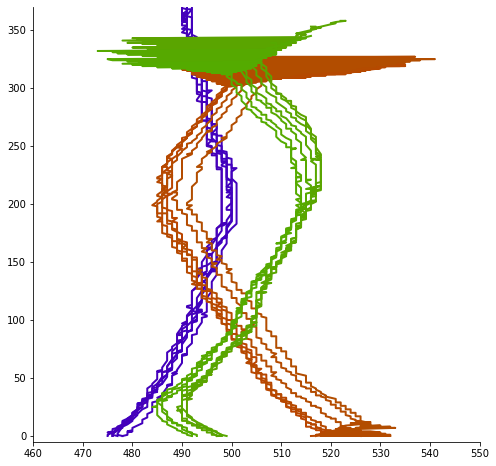

In [13]:
window_size = 10

plt.figure(figsize=(8, 8))
for sframe in selected_frames:  # rot_thin[::2]for nth, line in enumerate(rot_thin_loaded):
    line = rot_thin[sframe]
    y, x = np.where(line != 0)
    y = y - y.max()# idx = y >= 25
    plt.plot(x, y * -1, "-", color=colors[sframe], lw=2)

plt.xlim(460,550);plt.ylim(-5,370);

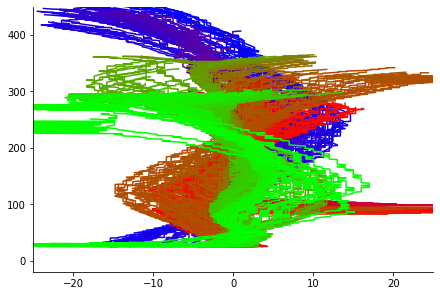

In [14]:
SAVE_FIGURES = False
#rot_thin[0]
fig, ax = plt.subplots(layout="constrained")
for nth, line in enumerate(rot_thin):  # for nth, line in enumerate(rot_thin_loaded):
    y, x = np.where(line != 0)
    y = y - y.min()
    idx = y >= 25
    x = x[idx] - x[idx].mean()
    y = y[idx]
    ax.plot(x, y, "-", color=colors[nth])
    #ax[0].invert_yaxis()

ax.set(xlim=(-25,25), ylim=(-20, 450))
if SAVE_FIGURES: fig.savefig(f"{save_figure_path}-skeleton.jpg", dpi=300)

# Corona Extension Process (March)
- this looks good actually, rüssel is frontal and elongated, lines do not bear the frontal triangle of corona
- corona transforms the lines that can be used to get the frontal width

## put into its own notebook, this last part!

/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_43340/3558033417.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # can also set limits in next cell or give back the ax handle?!


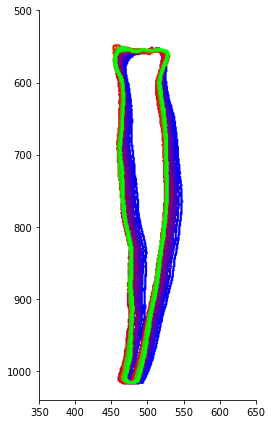

In [41]:
SAVE_FIGURES = False
plt.rcParams['figure.facecolor'] = 'white'
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)

# Frame selection
interval = 1
selected_frames = np.arange(30, 60, interval) # 0:30 transformation
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(selected_frames))]

#scalebar_posxy = [550, 1000]
cxlim = [350, 650]; cylim = [500, 1040]
background = np.ones_like(cv2.imread(sub_maskpaths[0])) * 255

# Draw selected contours
for nth, sframe in enumerate(selected_frames):
    ccolors = colors[nth] # colors[sframe]
    cv2.drawContours(background, [rot_contours[sframe]], 0, (ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255), 2)

# Figure
plt.figure(figsize=(5,6), layout="constrained")
plt.imshow(background)
plt.xlim(cxlim); plt.ylim(cylim);
plt.gca().invert_yaxis(); #plt.axis("off")

# Scalebar
#plt.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=3)
#plt.text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] - 15, f"{desired_scale_width} µm", size="x-large")
plt.tight_layout() # can also set limits in next cell or give back the ax handle?!

#if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-fps_{fps}-subsampled_selected-frames.jpg", dpi=300)

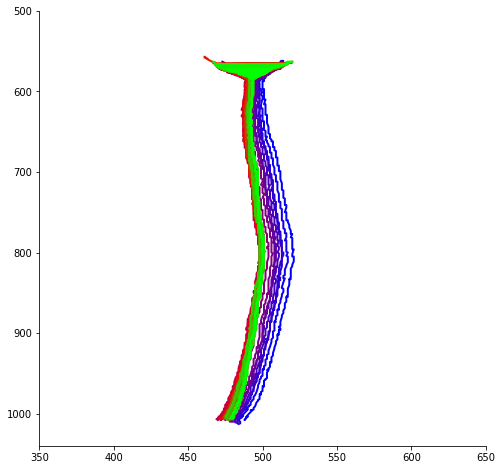

In [43]:
plt.figure(figsize=(8, 8))
for nth, sframe in enumerate(selected_frames):
    line = rot_thin[sframe]
    y, x = np.where(line != 0)
    plt.plot(x, y, "-", color=colors[nth], lw=2)

plt.xlim(cxlim); plt.ylim(cylim);
plt.gca().invert_yaxis()

In [ ]:
# get the df values accordingly